# Surrogates - Monte Carlo Simulations, Null Hypothesis Testing and Constrained Realizations
### December 19th, 2022 Luca Gawalleck

## Motivation

- analyzing signals i.e. time series 

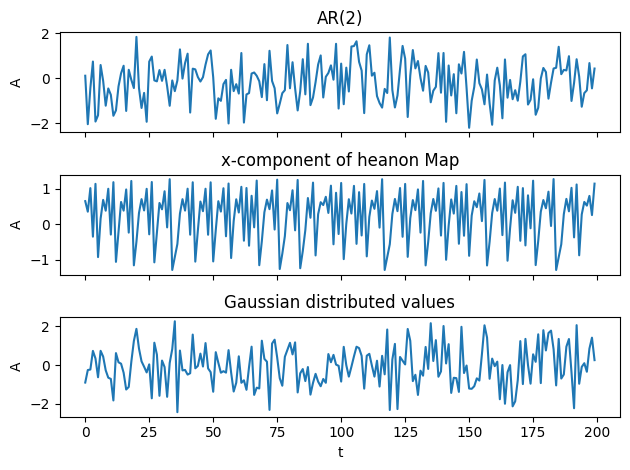

In [19]:
from pytisean import tiseano, tiseanio
import numpy as np
import matplotlib.pyplot as plt
# import scipy.signal as ss
import time
# import pandas as pd

def autocorrelation(x): 
    # -p for periodic continuation
    n = len(x)
    result, msg = tiseanio('autocor', '-p', data=x, silent=True)
    return result[:n//2,1]

def powerspektrum(x):
    result, msg = tiseanio('spectrum', data=x, silent=True)
    return result[:,0], result[:,1]

def match_signal(time_series):
    endtoend, msg = tiseanio('endtoend', data=ar2_data, silent=True)
    truncate_sig, msg = tiseanio('choose', f'-x{endtoend["offset"]}', f'-l{endtoend["length"]}', data=time_series, silent=True)
    # subtrac mean
    mu = truncate_sig.mean()
    return truncate_sig-mu

# creating an AR2 time_series
parameter = np.array([1, 0.1,0.1, 1]) #amplitude and coefficents
ar2_data, msg = tiseanio('ar-run', '-l200', '-p2', data=parameter
, silent=True)

# creating henon map
henon, msg = tiseano('henon', '-l200', silent=True)

# gausssian distribution
gauss = np.random.normal(0,1, size=200)

fig, axes = plt.subplots(3, sharex=True)
axes[0].plot(ar2_data)
axes[0].set_title("AR(2)")
axes[0].set_ylabel("A")
axes[1].plot(henon[:,0])
axes[1].set_title("x-component of heanon Map")
axes[1].set_ylabel("A")
axes[2].plot(gauss)
axes[2].set_title("Gaussian distributed values")
axes[2].set_ylabel("A")
axes[2].set_xlabel("t")
plt.tight_layout()
plt.show()

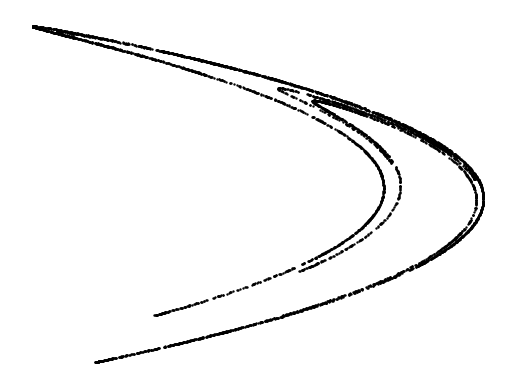

In [20]:
henon, msg = tiseano('henon', '-l5000', silent=True)
plt.scatter(henon[:,0], henon[:,1], s=0.5, color='k')
plt.axis('off')
plt.show()

- different optics but not possible to make quantified statements
- with more measurements it is possible to compare the statistics like correlation or mean
- need a method for testing $\rightarrow$ Hypothesis testing

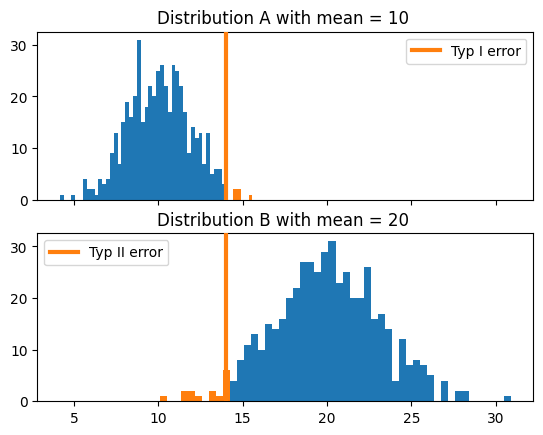

In [21]:
gauss_0 = np.random.normal(10, 2, 500)
gauss_1 = np.random.normal(20,3, 500)

fig, axes = plt.subplots(2, sharex=True)
N, bins, patches = axes[0].hist(gauss_0, bins=50,  linewidth=0.5, color="tab:orange")
alpha_area = 2*2+10
i = 0
while bins[i] < alpha_area:
    patches[i].set_facecolor('tab:blue')
    i+=1
N, bins, patches = axes[1].hist(gauss_1, bins=50, linewidth=0.5, color="tab:blue")
i = 0
while bins[i] < alpha_area:
    patches[i].set_facecolor('tab:orange')
    i+=1
axes[0].axvline(x=alpha_area ,ymin=-1.2,ymax=1,c="tab:orange",linewidth=3,zorder=5, clip_on=True, label="Typ I error")
axes[1].axvline(x=alpha_area ,ymin=0,ymax=1,c="tab:orange",linewidth=3,zorder=5, clip_on=True, label="Typ II error")
axes[0].set_title("Distribution A with mean = 10 ")
axes[1].set_title("Distribution B with mean = 20 ")
axes[0].legend()
axes[1].legend(loc='upper left')
plt.show()

## Null Hypothesis (NH)

- asking yes or no questions (nongaussian, mean nonzero, correlation, nonlinearity in correlation, chaos)
- aim is to disprove (with a certain probability) the opposite. This opposite is the Null Hypothesis
- accept and reject the hypothesis, by showing, that the data are unlike/like results from the hypothesis
- for that discriminating statistics $T$ is calculated
- rejecting the null hypothesis means, that if it were true it is unlikely this value would be observed


|             | $H_0$ |  $H_1$ |
| ----------- | ----------- | ----------- |
| Result $H_0$      | correct       | Typ II error ($\beta$ error) |
| Result $H_1$    | Type I error ($\alpha$ error)        | correct |

- *size* $\alpha$ corresponds to acceptance rate normally set to $\alpha=0.05$
-  $1-\beta$ is the *power* of the test and influenced by underlying process and $n$

Distinguish between **simple** and **composite** NH:
let $\mathcal{F}$ be the space of considered processes and $\mathcal{F}_\phi \subset \mathcal{F}$ the processes, which are consistent with NH. If there are just one process $F\in\mathcal{F}_\phi$ then the HM is simple, otherwise its composite. In composite case, the NH just say that there are some process $F\in\mathcal{F}_\phi$, but not which process specific. 



## Surrogates
- problem: there is just a single measurement of a system 
- more data needed
- create multiple versions of a given time series with same statistical properties
- two main types
  - **typical realizations:** fit a model the data and vary the noise
    - problems occurs if NH is composite, then its not clear which process should be simulated 
    - to avoid this $T$ has to be **pivotal** i.e. the distribution of $T$ is the same $\forall F \in \mathcal{F}_\phi$
    - often only given in the limit $n\to\infty$
  - **constrained realizations:** produce surrogates directly from the data by conserving all properties except the one that should be tested
    - behaves like $T$ is pivotal even its not, so they can used more widely for different NH
    - just for NH not for confidence intervals
- there are an finit number of variation for surrogates, so the upper limit is this number
- the minimal number can also be found if the variation of the standard deviation doesen't change anymore with a higher number of surrogates
- number of surrogates $M=\frac{K}{\alpha}-1$ for $K$ is a positiv integer. For a two sided test, $K$ should be at least 2 [Lancaster2018](https://reader.elsevier.com/reader/sd/pii/S0370157318301340?token=9C5C6E84692DF478CBE66439D8A646FA785D0C739620C900446EF6C9E220346F673C48C1F6683226444D2C303B2829F3&originRegion=eu-west-1&originCreation=20221215170415)

## Monte Carlo
- need to set confidence interval of $T$ to $95\%$ i.e. $\alpha=0.05$ Form von T irrelevant 
  - straightforward possible with standard distributions  
- to calculate this for any distribution Monte Carlo technics are useful
    - compute many random realizations of the NH and compute $T$
    - measure resulting distribution
- measuring confidence intervals give error bars for a statistic of the data like the mean or the fractal dimension
- other possibility is to test if the data are consistent with the hypothesis.


In [22]:
def plot_surrogates(time_series, surrogate_method):
    time_series_surrogate = surrogate_method(time_series)
    fig = plt.figure(constrained_layout=True)
    fig.set_size_inches(8,5)
    mean = np.mean(time_series)
    std = np.std(time_series)
    mean_surrogate = np.mean(time_series_surrogate)
    std_surrogate = np.std(time_series_surrogate)
    grid = plt.GridSpec(2,4, figure=fig)
    axs = []
    axs.append(plt.subplot(grid[0, :2]))
    axs.append(plt.subplot(grid[1, 0]))
    axs.append(plt.subplot(grid[0, 2:]))
    axs.append(plt.subplot(grid[1, 2:]))
    axs.append(plt.subplot(grid[1, 1], sharey=axs[1]))
    
    axs[0].set_title("time series")
    axs[0].plot(time_series, label=f"Original: mean={mean:.2f}, std={std:.2f}")
    axs[0].plot(time_series_surrogate, label=f"Surrogate: mean={mean_surrogate:.2f}, std={std_surrogate:.2f}")
    axs[0].set_xlabel("time steps")
    axs[0].set_ylabel("value")
    # axs1 = axs[1].subplots(2)
    # axs2 = axs[1].subplot2grid((1,1), (0, 1))
    # ax2 = axs[0].axes([0.5, 0.5, 0.25, 0.25])
    # axs[1] = subplot
    axs[1].set_title("Autocorrelation")
    axs[1].plot(autocorrelation(time_series))
    axs[1].plot(autocorrelation(time_series_surrogate))
    axs[1].set_xlabel("r")
    axs[1].set_ylabel("$C(r)$")
    axs[2].set_title("Power Spectrum")
    f, Pxx = powerspektrum(time_series) # calculate power spectrum
    axs[2].plot(f, Pxx)
    f_s, Pxx_s = powerspektrum(time_series_surrogate)
    axs[2].plot(f_s, Pxx_s)
    axs[2].set_xlabel("frequencys")
    axs[2].set_ylabel("power")
    axs[3].hist(time_series)
    axs[3].hist(time_series_surrogate)
    axs[3].set_xlabel("values")
    axs[3].set_ylabel("occurance")

    axs[4].set_title("Autocorrelation")
    axs[4].plot(autocorrelation(time_series)[:10])
    axs[4].plot(autocorrelation(time_series_surrogate)[:10])
    axs[4].set_xlabel("r")
    plt.setp(axs[4].get_yticklabels(), visible=False)

    fig.legend(bbox_to_anchor=(1,1), loc='lower center')
    plt.tight_layout()
    plt.plot()
    return



### Testing for IID (idependent and identically distributed) data

Used to find out if data are just white Gaussian noise or test for non-Gaussian distribution

**Null Hypothesis**: The data are independent and identically distribution 

**Surrogate Methode**: Random Shuffle (RS)

**Algorithm**: permute the values of the time series random

- mean and standard derivation and value histogram are preserved while every correlation are destroyed. 

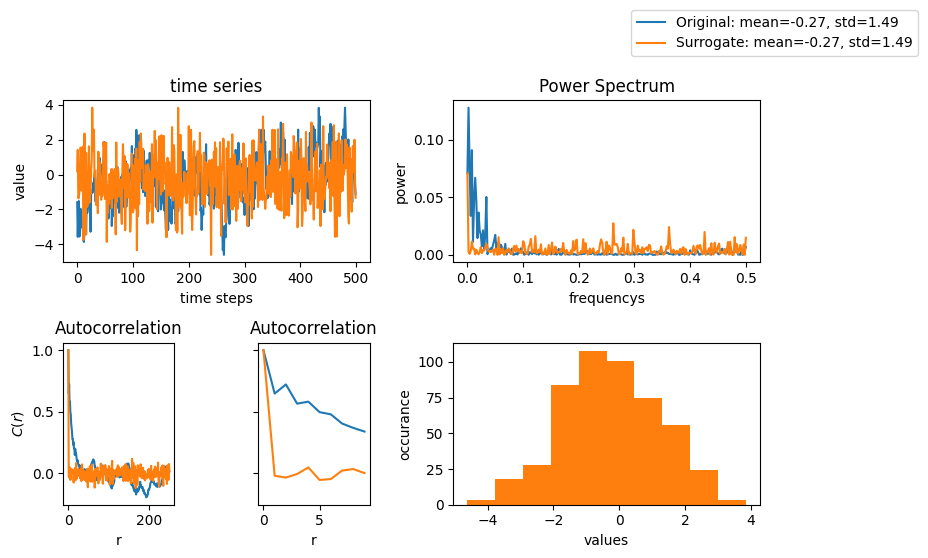

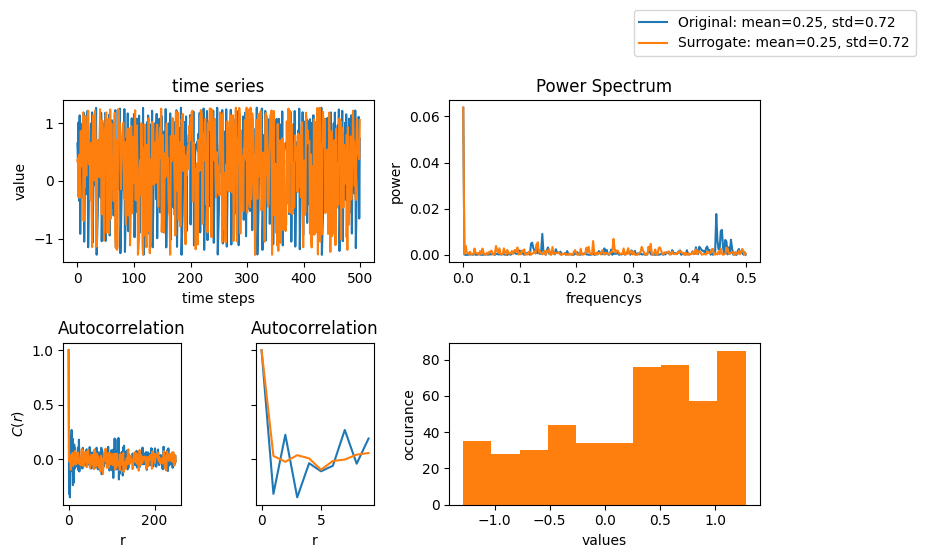

In [23]:
def RS(time_series):
    """
        shuffles the values of the time series
    """
    RS_surrogate = np.copy(time_series)
    np.random.shuffle(RS_surrogate)
    return RS_surrogate

parameter = np.array([1, 0.33, 0.5, 1])
ar2_data, msg = tiseanio('ar-run', '-l500', '-p2', data=parameter, silent=True)

# creating henon map
henon, msg = tiseano('henon', '-l500', silent=True)

plot_surrogates(ar2_data, RS)

plot_surrogates(henon[:,0], RS)


**discriminating statistic** e.g. autocorrelation at lag 1:

\begin{gather}
T = A(1) = \frac{1}{n-1} \sum_{i=0}^{n}(x(i)-\overline{x})\frac{(x(i+1)-\overline{x})}{\overline{(x-\overline{x})^2}} \quad \text{with} \quad \overline{(x-\overline{x})^2} = \sqrt{\frac{1}{n}\sum_{i=0}^n (x(i)-\overline{x})^2}
\end{gather}


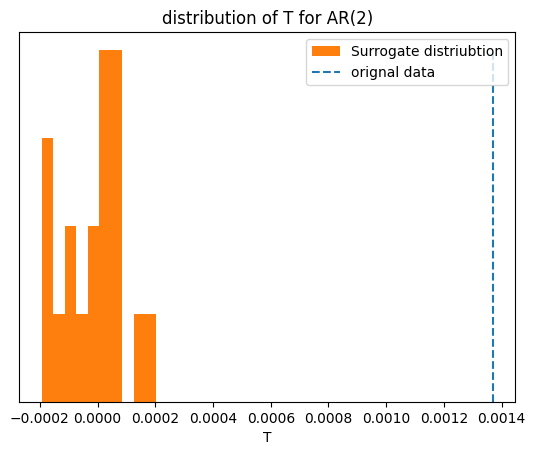

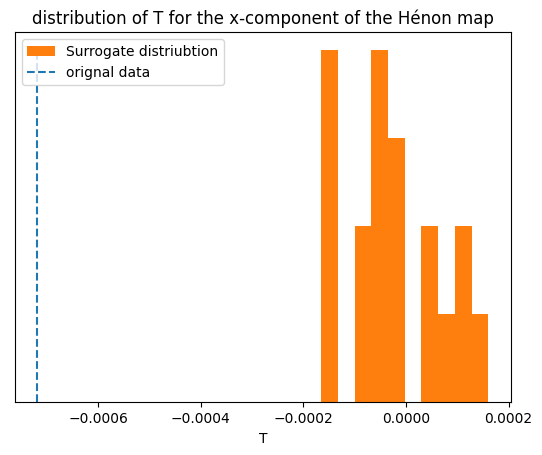

In [24]:
def A1(x):
    n = x.shape[0]
    # print(n)
    mu = x.mean()
    denominator = 0 
    for i in range(n):
        denominator += (x[i]-mu)**2
    denominator/n

    result = 0
    for i in range(n):
        result += (x[i]-mu)*(x[(i+1)%n]-mu)/denominator
    return result/(n-1)


def plot_dis_statistic(test_statistic, data, surrogate, title=False):
    data = match_signal(data)
    T_values = []
    for i in range(19):
        surr = surrogate(data)
        T_value = test_statistic(surr)
        T_values.append(T_value)

    n, bins, poatches = plt.hist(T_values, color='tab:orange', label='Surrogate distriubtion')    
    plt.xlabel("T")
    plt.vlines(test_statistic(data),0,max(n), color='tab:blue', linestyles='dashed', label='orignal data')
    plt.yticks([])
    plt.legend()
    if title != False:
        plt.title(title)
    plt.show()

plot_dis_statistic(A1, ar2_data, RS, "distribution of T for AR(2)")
plot_dis_statistic(A1, henon[:,0], RS, "distribution of T for the x-component of the Hénon map")

## Testing for Nonlinearity

- bevor apply techniques for analysis nonlinear systems, this methods must be justified by non linearity in the time series.
- it is not possible to test directly for chaos in a time series. Since chaos implies nonlinearity it can at least tested, if there are indications for nonlinearity

- Random shuffling is not useful instead techniques are needed that preserve the autocorrelation function of the original data. 
  
**Null Hypothesis**: Data generated by linear stationary process probably with noise and can be fully characterized by *mean*, *standard deviation* and autocorrelation. 
    - this means that rejecting the NH could also mean, that the process is linear but nonstationarity
    - nonstationarity i.e. that the statistical properties are invariant has to be proven beforehand
      - wavelet based surrogates, that preserve the local mean and variance are useful for testing nonstationarity
      - in the following stationary time series are assumed 

- After the Wiener-Khinchin theorem preserving the periodic autocorrelation the power spectrum is also preserved
 

- Algorithm based on Fourier

## Preprocessing 

  - removing trends that are not important 
  - correct any mismatch between start and endpoints for the data and the first derivatives i.e. the number of periods of oscillations has to be an integer
    - otherwise this cause a numerical artifact and the Fourier based surrogate has perturbations s.t. a linear signal can look nonlinear
    - a possible mismatch can be seen as a $\theta$-Function, the derivation of that is a $\delta$-peak and the Fourier transform of a $\delta$-peak is a constant 
    - a window function to reduce this problem is not possible because they are not linear
    - the match can be achieved by truncate the signal s.t. the system simulates a infinit signal through nearby periodic boundary conditions
  - subtract the mean


### FT

Null Hypothesis: data come from linear gaussian prozess

- FFT
- random phases $\phi$ s.t. $\phi(f)=-\phi(-f)$ 
- IFFT


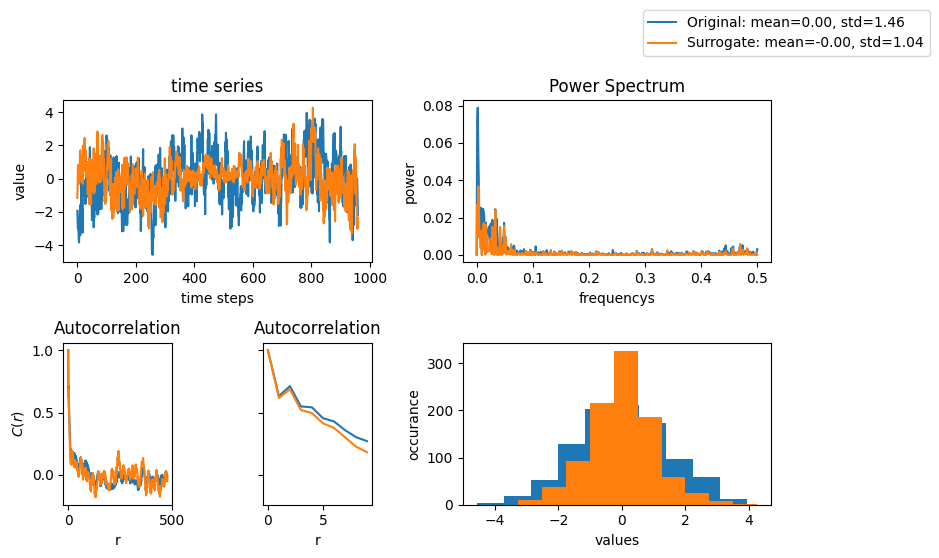

In [30]:
def FT(time_series):
    ft = np.fft.fft(time_series)
    phase = np.angle(ft) #phase of the complex fourier values
    # print(np.imag(ft))
    amp = np.abs(ft) # amplitudes of the complex fourier values
    # print(amp)

    n = len(ft)
    # constrained that phi(f) = -phi(-f) that ifft is real
    if n % 2 == 0:
        half_phase = np.random.uniform(0,2*np.pi, n//2)
        phase = np.append(half_phase, -np.flip(half_phase))
    else:
        half_phase = np.random.uniform(0,2*np.pi, n//2+1)
        phase = np.append(0, np.append(half_phase[:-1], np.append([half_phase[-1]], -np.flip(half_phase[:-1]))))

    value = np.fft.ifft( amp* np.exp(phase*1j))
    return np.real(value) # todo img actually not zero

parameter = np.array([1, 0.33, 0.5, 1])
ar2_data, msg = tiseanio('ar-run', '-l1000', '-p2', data=parameter, silent=True)

# creating henon map
henon, msg = tiseano('henon', '-l1000', silent=True)

ar2_data_truncate = match_signal(ar2_data)
plot_surrogates(ar2_data_truncate, FT)


- Autocorrelation and power spectrum fits more or less
- Amplitude distribution is gaussian and does not preserve the original data

Possible extension to **truncated Fourier transform surrogate** which has a frequency threshold. Under this threshold the $\phi$ stay the same above $\phi$ are randomized, so just long-term trends are preserved while short-term variability is randomized. So nonlinearity can be observed even though there are short-term fluctuations.

### AAFT

Null Hypothesis:
underlaying time series $\{y_i\}$ consistent with the null hypothesis of linear gaussian noise. The observed time series $\{x_i\}$ is given by $x_i = h(y_i)$. Monotonic nonlinear transformation of a linear gaussian process.

- rescale values to be gaussian
- apply FT (same Fourier spectrum)
- rescale back to have same amplitude distribution

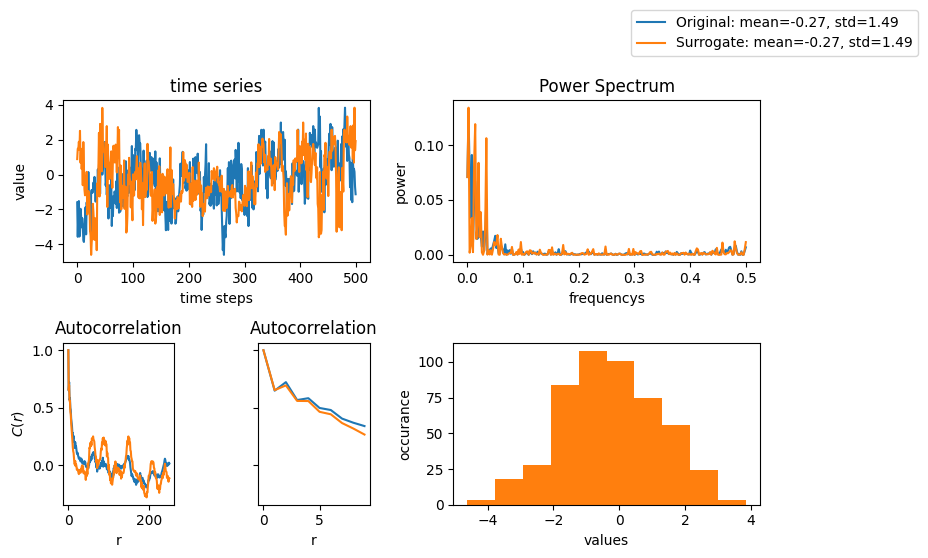

In [26]:
def AAFT(time_series):
    x = time_series.copy()
    n = len(x)

    # get indices for ranks of time_series
    T = np.argsort(x)
    ranks = np.argsort(T)
    x = np.sort(x)

    # create random gaussian distribution and sort them, that the ranks fits to the time series
    y = np.random.normal(0,1,n)
    y = np.sort(y)
    y = y[ranks]

    # random shift phase
    y_prime = FT(y)
    T = np.argsort(y_prime)
    ranks = np.argsort(T)
    x = x[ranks]
    return x


plot_surrogates(ar2_data, AAFT)

- autocorrelation and power spectrum preserved
- Amplitudes now not Gaussian anymore instead identical to original time series

### IAAFT

- improvement for AAFT, that minimize the errors of the FFT cause of not infinit time series 
- pepeats AAFT and calculate difference in power spectrum to original data
- stops at a fixed numer of iterations or after a convergence criteria is reached
- surrogate is identical to the original for to many iterations

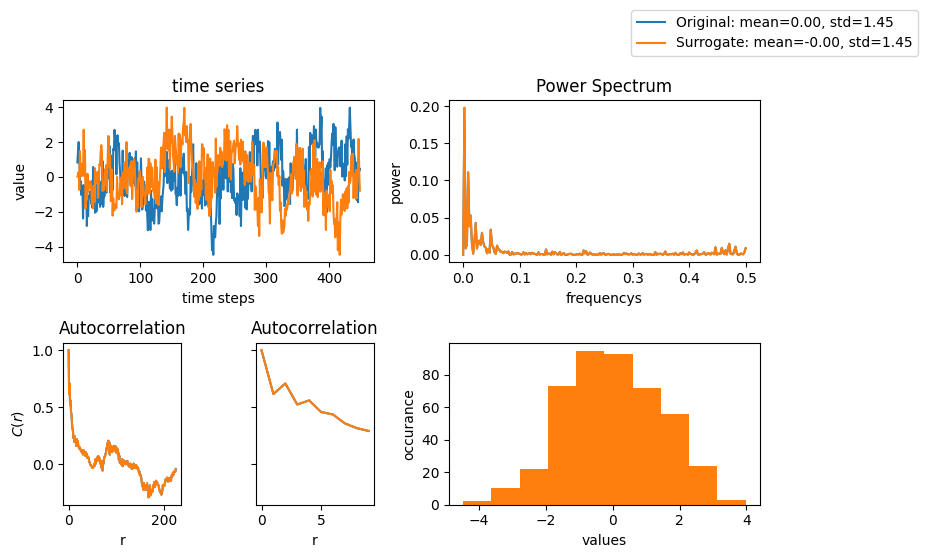

In [27]:
def IAAFT(time_series):
    seed = np.random.randint(100,1000)
    IAAFT_surr, msg = tiseanio('surrogates', f'-I{seed}', silent=True, data=time_series)
    return IAAFT_surr

plot_surrogates(ar2_data_truncate, IAAFT)

- still slightly difference to the original data 
- autocorrelation and power spectrum is conserved a lot better than with FT or AFFT
- amplitudes are still preserved

discriminating statistics for nonlinearity [Theiler,Prichard](https://doi.org/10.1016/0167-2789(96)00050-4):
\begin{gather}
    T = \frac{\langle(x(i+1)-x(i))^3 \rangle}{\langle (x(i+1)-x(i))^2 \rangle^{3/2} } + 20A(1)
\end{gather}

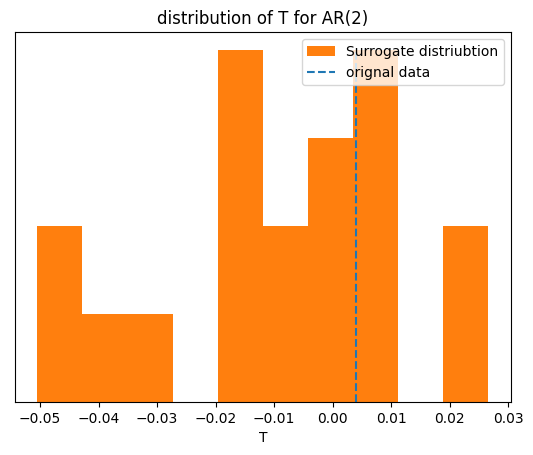

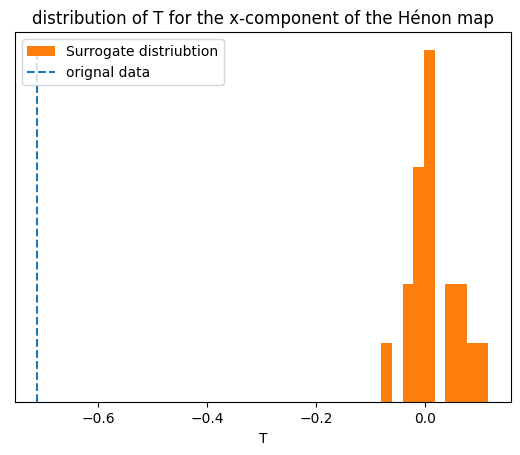

In [34]:
henon, msg = tiseano('henon', '-l1000', silent=True)
trunc_henon_x = match_signal(henon[:,0])

def T(x):
    n = x.shape[0]
    numerator = 0
    denominator = 0
    for i in range(n):
        numerator += (x[(i+1)%n]-x[i])**3 
        denominator += (x[(i+1)%n]-x[i])**2
    numerator/=n
    denominator/=n 
    result = numerator / ( (denominator)**(3/2) ) + 20*A1(x)
    return result

plot_dis_statistic(T, ar2_data, RS, "distribution of T for AR(2)")
plot_dis_statistic(T, henon[:,0], RS, "distribution of T for the x-component of the Hénon map")

## Delay-coordinate embedding

- helpful if the measurement contains e.g. just x-data
- reconstructing space from one axis of the phase space 

with $x(t), x(t-\tau), x(t-2\tau), \ldots$ as axis

### Takens's Theorem
For the right $\tau$ and enough dimensions $m$ the embedded dynamics have the same topology as the original state-space dynamics

### Correlation Dimension

***pointwise dimension*** $d_\mathrm{p}$: number of points $N_x(\varepsilon)$ within $\varepsilon$ around a point $x$
\begin{gather}
N_x(\varepsilon) \propto \varepsilon^{d_\mathrm{p}}
\end{gather}

***correlation dimension*** $d_\mathrm{corr}$: average $N_x(\varepsilon)$ over lots of $x$: $N_x(\varepsilon)\to C(\varepsilon)$

\begin{gather}
C(\epsilon) \propto \varepsilon^{d_\text{corr}}\\
C(\varepsilon) =\frac{1}{N(N-1)} \sum_{i=1}^N\sum_{j=i+1}^N \Theta(\varepsilon-||x_i-x_j||)\\
\end{gather}


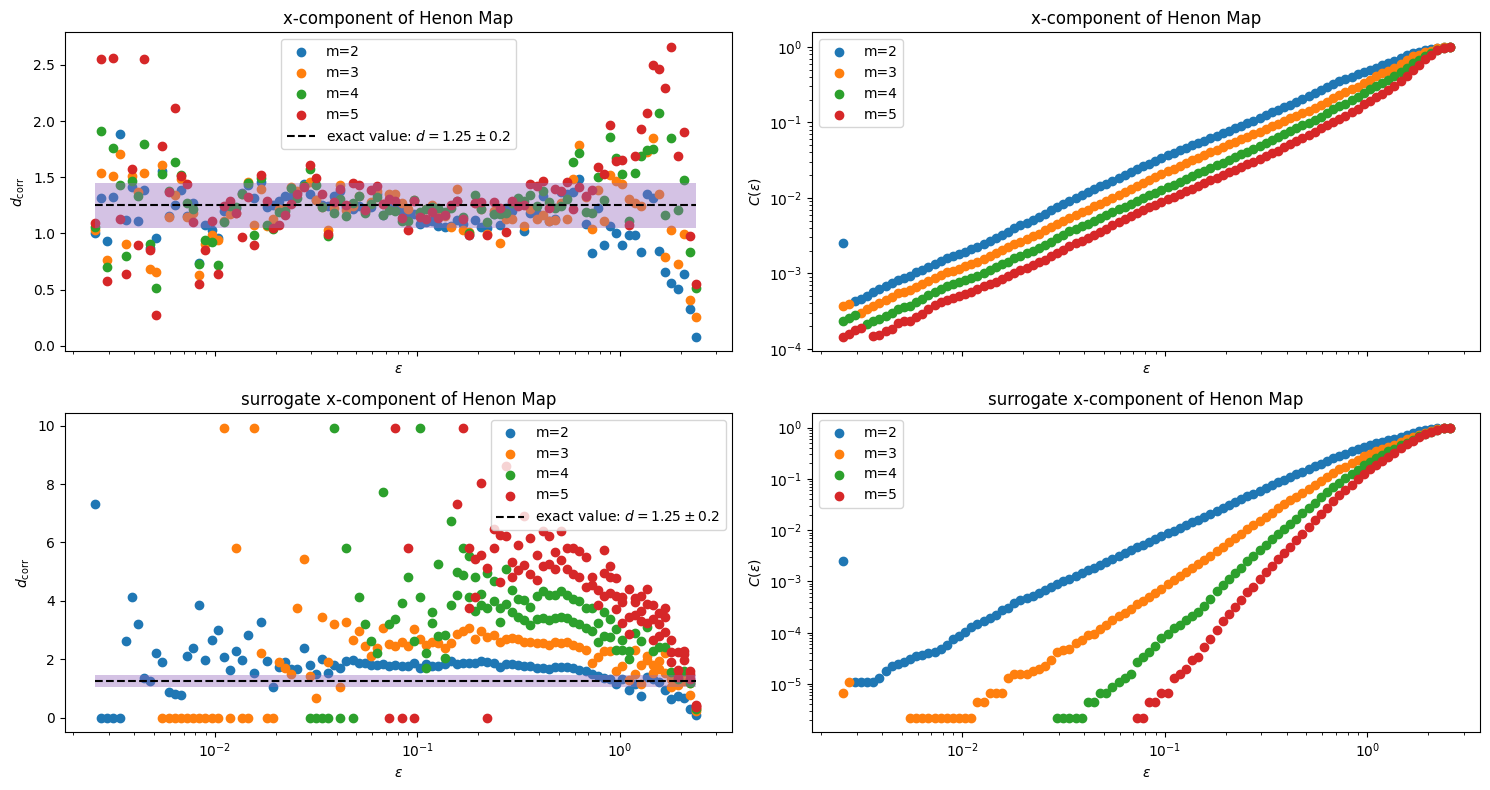

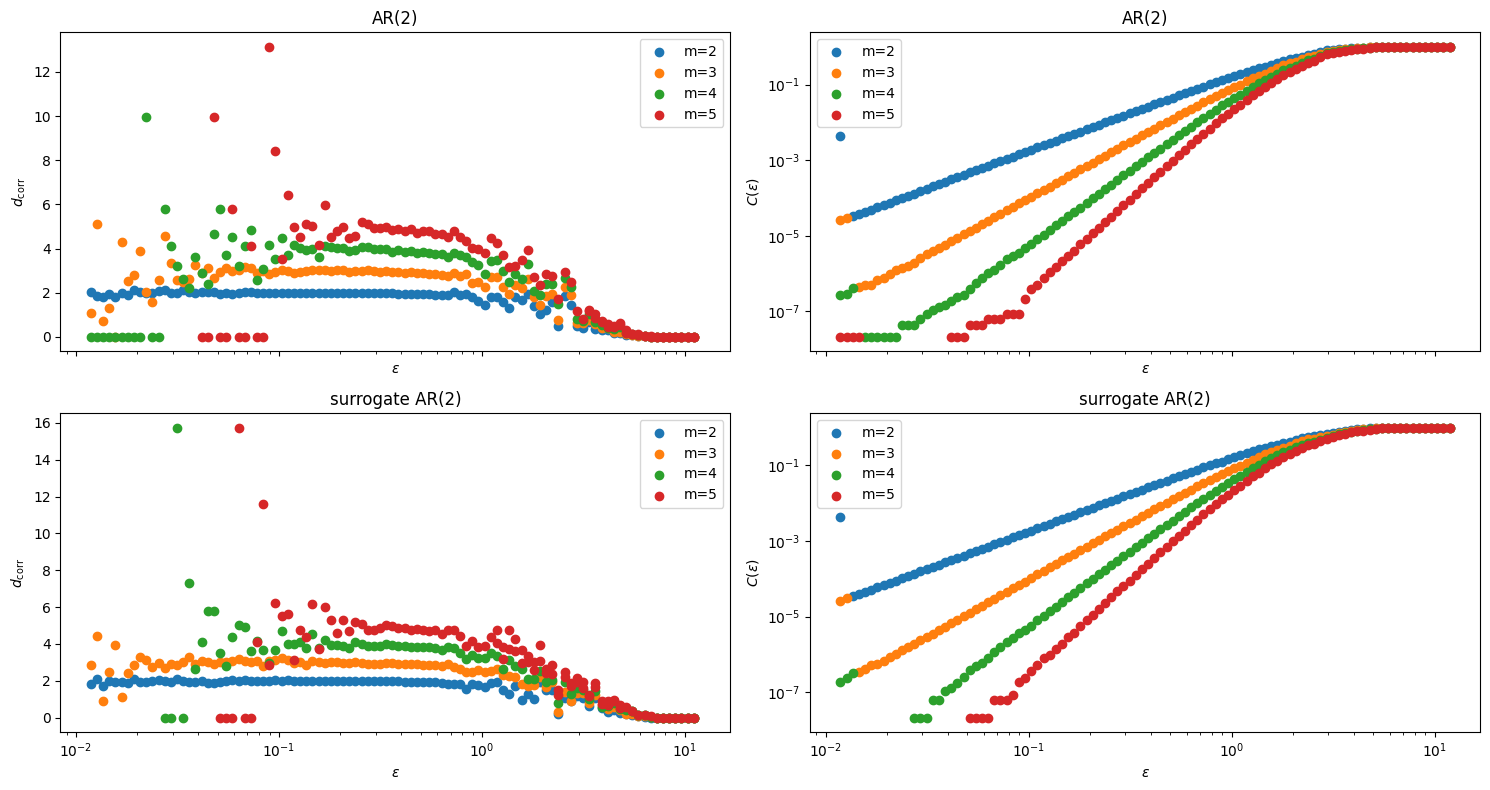

In [33]:
def plot_corr_dim(d2, ax, value_exact=False, error=False, title=False):
    corr_dim = d2[0]
    dim = np.arange(0, len(corr_dim), 99)
    for m in range(1,5):
        ax.scatter(corr_dim[dim[m]:dim[m+1],0], corr_dim[dim[m]:dim[m+1],1], label=f"m={m+1}")
    if value_exact != False:
        ax.hlines(value_exact, min(corr_dim[:,0]), max(corr_dim[:,0]), label=f'exact value: $d = {value_exact}\pm {error}$', linestyle='dashed', color='k')
        if error != False:
            ax.fill_between([min(corr_dim[:,0]), max(corr_dim[:,0])],  2*[value_exact+error],  2*[value_exact-error], alpha=0.4)
    ax.set_xscale('log')
    ax.set_xlabel("$\\varepsilon$")
    ax.set_ylabel("$d_\mathrm{corr}$")
    ax.legend()
    if title != False:
        ax.set_title(title)

def plot_corr_sum(d2, ax, title=False, value_exact=False, error=False):
    corr_sum = d2[1]
    dim = np.arange(0, len(corr_sum), 99)
    for m in range(1,5):
        ax.scatter(corr_sum[dim[m]:dim[m+1],0], corr_sum[dim[m]:dim[m+1],1], label=f"m={m+1}")

    # if value_exact != False:
    #     x = np.linspace(min(corr_sum[:,0]), max(corr_sum[:,0]), 3)
    #     y = value_exact*x
    #     ax.plot(x,y, label=f'exact value: $d = {value_exact}\pm {error}$', linestyle='dashed', color='k')
    #     if error != False:
    #         ax.fill_between([min(corr_sum[:,0]), max(corr_sum[:,0])],  2*[value_exact+error],  2*[value_exact-error], alpha=0.4)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("$\\varepsilon$")
    ax.set_ylabel("$C(\\varepsilon)$")
    ax.legend()
    if title != False:
        ax.set_title(title)


def plot_corr(data, name, value_exact=False, error=False):

    fig, axes = plt.subplots(2, 2, sharex=True)
    fig.set_size_inches(15,8)

    d2, msg = tiseanio('d2', data=data, silent=True)

    plot_corr_dim(d2, axes[0,0], value_exact=value_exact, error=error, title=name)
    plot_corr_sum(d2, axes[0,1], value_exact=value_exact, error=False, title=name)

    sur = IAAFT(data)
    d2_surr, msg = tiseanio('d2', data=sur, silent=True)

    plot_corr_dim(d2_surr, axes[1,0], value_exact=value_exact, error=error, title=f"surrogate {name}")
    plot_corr_sum(d2_surr, axes[1,1], title=f"surrogate {name}")

    fig.tight_layout()
    plt.show()


henon, msg = tiseano('henon', '-l10000', silent=True)
henon_x_trunc = match_signal(henon[:,0])

plot_corr(henon_x_trunc, 'x-component of Henon Map', 1.25, 0.2)

parameter = np.array([1,0.33,0.5,1])

ar2_data, msg = tiseanio('ar-run', '-l10000', '-p2', data=[1,0.33,0.5,1]
, silent=True)
ar2_data_truncate = match_signal(ar2_data)

plot_corr(ar2_data_truncate, 'AR(2)')


### Surrogate technics for EEG data 

todo
- EEG data chaotic according to many studies
- used for epilepsy patients shows that nonlinear methods in combination with surrogates had higher accuracy


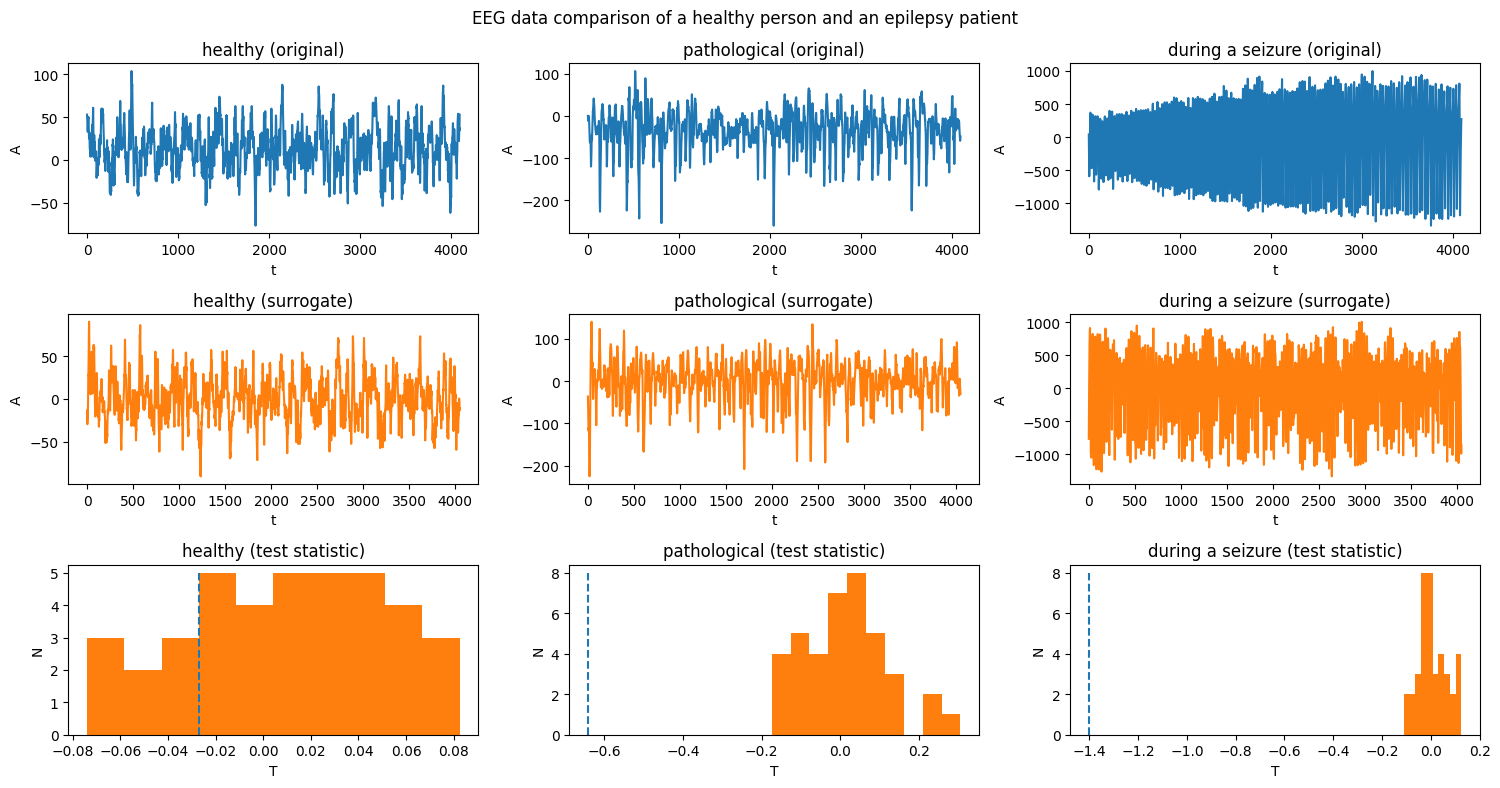

In [ ]:
EEG = dict()
EEG_surr = dict()

EEG['normal'] = np.loadtxt("data/fc11b000.txt")
EEG['path'] = np.loadtxt("data/fb1b0000.txt")
EEG['ep'] = np.loadtxt("data/sc4b0000.txt")


fig, axs = plt.subplots(3,3)
fig.set_size_inches(15,8)



j = 0
for key in EEG:
    T_values = []

    axs[0, j].plot(EEG[key])

    for i in range(39):
        EEG_surr[f'{key}'] = IAAFT(match_signal(EEG[key]))
        T_value = T(EEG_surr[f'{key}'])
        T_values.append(T_value)

    n, bins, poatches = axs[2,j].hist(T_values, color='tab:orange', label='Surrogate distriubtion')    
    axs[2,j].set_xlabel("T")
    axs[2,j].set_ylabel("N")
    axs[1,j].set_xlabel("t")
    axs[1,j].set_ylabel("A")
    axs[0,j].set_xlabel("t")
    axs[0,j].set_ylabel("A")
    axs[2,j].vlines(T(EEG[f'{key}']),0,max(n), color='tab:blue', linestyles='dashed', label='orignal data')
    
    axs[1, j].plot(EEG_surr[f'{key}'], color="tab:orange")
    j+=1

axs[0,0].set_title("healthy (original)")
axs[1,0].set_title("healthy (surrogate)")
axs[2,0].set_title("healthy (test statistic)")
axs[0,1].set_title("pathological (original)")
axs[1,1].set_title("pathological (surrogate)")
axs[2,1].set_title("pathological (test statistic)")
axs[0,2].set_title("during a seizure (original)")
axs[1,2].set_title("during a seizure (surrogate)")
axs[2,2].set_title("during a seizure (test statistic)")
fig.suptitle("EEG data comparison of a healthy person and an epilepsy patient")
fig.tight_layout()
plt.show()